In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import hdbscan

In [2]:
data = pd.read_csv("~/ip_timeseries/train_timeseries.csv")

In [3]:
# imamo jedan object: date
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19300680 entries, 0 to 19300679
Data columns (total 21 columns):
 #   Column       Dtype  
---  ------       -----  
 0   fips         int64  
 1   date         object 
 2   PRECTOT      float64
 3   PS           float64
 4   QV2M         float64
 5   T2M          float64
 6   T2MDEW       float64
 7   T2MWET       float64
 8   T2M_MAX      float64
 9   T2M_MIN      float64
 10  T2M_RANGE    float64
 11  TS           float64
 12  WS10M        float64
 13  WS10M_MAX    float64
 14  WS10M_MIN    float64
 15  WS10M_RANGE  float64
 16  WS50M        float64
 17  WS50M_MAX    float64
 18  WS50M_MIN    float64
 19  WS50M_RANGE  float64
 20  score        float64
dtypes: float64(19), int64(1), object(1)
memory usage: 3.0+ GB


In [4]:
# sadrži NaN vrednosti u score
data.isna().any()

fips           False
date           False
PRECTOT        False
PS             False
QV2M           False
T2M            False
T2MDEW         False
T2MWET         False
T2M_MAX        False
T2M_MIN        False
T2M_RANGE      False
TS             False
WS10M          False
WS10M_MAX      False
WS10M_MIN      False
WS10M_RANGE    False
WS50M          False
WS50M_MAX      False
WS50M_MIN      False
WS50M_RANGE    False
score           True
dtype: bool

In [5]:
# izbacujemo sve vrste sa NaN za score
# score se meri samo jednom u nedelju dana
# resetujemo indeks da bi počinjao od 0
data = data[data['score'].notnull()].reset_index(drop=True)
data

,fips,date,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,...,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,score
0,1001,2000-01-04,15.95,100.29,6.42,11.40,6.09,6.10,18.09,2.16,...,11.31,3.84,5.67,2.08,3.59,6.73,9.31,3.74,5.58,1.0
1,1001,2000-01-11,1.33,100.40,6.63,11.48,7.84,7.84,18.88,5.72,...,10.43,1.76,2.48,1.05,1.43,3.55,6.38,1.71,4.67,2.0
2,1001,2000-01-18,1.11,100.39,9.53,14.28,13.26,13.26,18.04,8.98,...,14.19,2.63,3.60,1.67,1.92,5.19,6.40,3.84,2.55,2.0
3,1001,2000-01-25,0.00,100.11,2.05,-0.78,-7.93,-7.72,5.65,-5.46,...,-0.61,3.35,4.59,2.28,2.32,5.75,8.03,3.96,4.07,2.0
4,1001,2000-02-01,0.00,101.00,3.36,2.06,-1.73,-1.70,11.02,-4.21,...,1.88,2.03,2.74,0.88,1.86,4.18,6.38,1.27,5.11,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2756791,56043,2016-11-29,0.04,82.47,2.19,-4.27,-9.36,-9.26,-1.51,-7.22,...,-4.38,6.93,10.27,3.08,7.18,9.42,12.59,5.62,6.97,0.0
2756792,56043,2016-12-06,0.13,82.59,0.91,-11.96,-18.65,-17.90,-6.85,-15.24,...,-11.98,2.27,3.97,0.95,3.02,3.07,5.16,0.83,4.33,0.0
2756793,56043,2016-12-13,0.02,82.86,1.40,-9.56,-14.18,-13.95,-2.69,-13.01,...,-10.95,3.64,6.59,1.28,5.31,5.33,8.35,2.13,6.22,0.0
2756794,56043,2016-12-20,0.32,83.12,2.73,-2.55,-6.90,-6.84,2.66,-7.77,...,-3.94,6.16,8.43,3.44,4.99,8.99,10.14,6.67,3.47,0.0


In [6]:
# formatiranje
# formatiranje datuma
data['year'] = pd.DatetimeIndex(data['date']).year
data['month'] = pd.DatetimeIndex(data['date']).month
data['day'] = pd.DatetimeIndex(data['date']).day
# i izbacivanje date pošto postaje redundantan
data = data.drop('date', axis = 1).reset_index(drop=True)
# formatiranje score-a
data['score'] = data['score'].round().astype(int)

In [7]:
# feature selection i feature extraction
# T2M_RANGE, WS10M_RANGE i WS50M_RANGE su redundantne i
# mogu da se izbace pošto imamo i max i min za ove vrednosti
data = data.drop('T2M_RANGE', axis = 1)
data = data.drop('WS10M_RANGE', axis = 1)
data = data.drop('WS50M_RANGE', axis = 1)

In [8]:
for i in data.columns:
    if i == 'fips' or i == 'day' or i == 'month' or i == 'year' or i == 'score':
        continue
    data = data[(data[f'{i}'] <= data[f'{i}'].mean() + 3 * data[f'{i}'].std())
              & (data[f'{i}'] >= data[f'{i}'].mean() - 3 * data[f'{i}'].std())]
# provera da li smo dobro izbacili outlier-e
data.shape

(2520551, 20)

In [9]:
X = data.drop('score', axis = 1)
X = X.drop('fips', axis = 1)
y = data['score']

In [10]:
scaler = MinMaxScaler()

X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(data=X_scaled, columns=X.columns)
X

,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,TS,WS10M,WS10M_MAX,WS10M_MIN,WS50M,WS50M_MAX,WS50M_MIN,year,month,day
0,0.743590,0.853091,0.275991,0.527251,0.586284,0.577686,0.532029,0.461951,0.499599,0.403409,0.427136,0.372760,0.564941,0.591195,0.430876,0.0,0.000000,0.100000
1,0.062005,0.857748,0.285781,0.528605,0.621687,0.613636,0.544494,0.525545,0.485471,0.167045,0.159966,0.188172,0.276113,0.386443,0.197005,0.0,0.000000,0.333333
2,0.051748,0.857324,0.420979,0.575999,0.731337,0.725620,0.531240,0.583780,0.545834,0.265909,0.253769,0.299283,0.425068,0.387841,0.442396,0.0,0.000000,0.566667
3,0.000000,0.845470,0.072261,0.321090,0.302650,0.292149,0.335753,0.325831,0.308236,0.347727,0.336683,0.408602,0.475931,0.501747,0.456221,0.0,0.000000,0.800000
4,0.000000,0.883150,0.133333,0.369160,0.428080,0.416529,0.420480,0.348160,0.348210,0.197727,0.181742,0.157706,0.333333,0.386443,0.146313,0.0,0.090909,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2520546,0.001865,0.098645,0.078788,0.262018,0.273720,0.260331,0.222783,0.294391,0.247712,0.754545,0.812395,0.551971,0.809264,0.820405,0.647465,1.0,0.909091,0.933333
2520547,0.006061,0.103726,0.019114,0.131855,0.085778,0.081818,0.138530,0.151125,0.125702,0.225000,0.284757,0.170251,0.232516,0.301188,0.095622,1.0,1.000000,0.166667
2520548,0.000932,0.115157,0.041958,0.172478,0.176209,0.163430,0.204165,0.190961,0.142238,0.380682,0.504188,0.229391,0.437784,0.524109,0.245392,1.0,1.000000,0.400000
2520549,0.014918,0.126164,0.103963,0.291131,0.323488,0.310331,0.288577,0.284566,0.254776,0.667045,0.658291,0.616487,0.770209,0.649196,0.768433,1.0,1.000000,0.633333


In [11]:
pca = PCA(n_components = 2)
X_pca = pca.fit_transform(X)

In [12]:
X_pca.shape

(2520551, 2)

In [79]:
clusterer = hdbscan.HDBSCAN(min_cluster_size = 10000, min_samples = 1)
clusterer.fit(X_pca)

HDBSCAN(min_cluster_size=10000, min_samples=1)

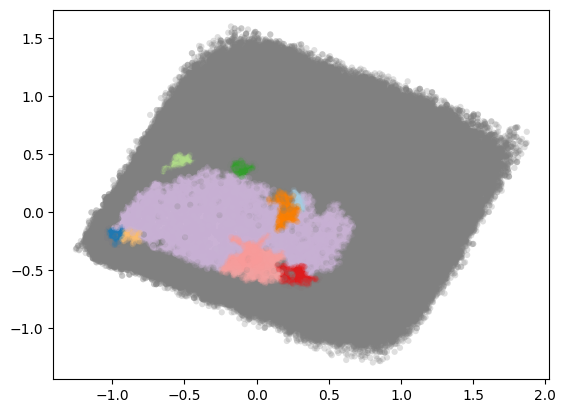

In [80]:
color_palette = sns.color_palette('Paired', 12)
cluster_colors = [color_palette[x] if x >= 0 and x <= 11
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]
plt.scatter(*X_pca.T, s=20, linewidth=0, c=cluster_member_colors, alpha=0.25)

In [81]:
labels = clusterer.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print('Estimated number of clusters: %d' % n_clusters_)

Estimated number of clusters: 9
